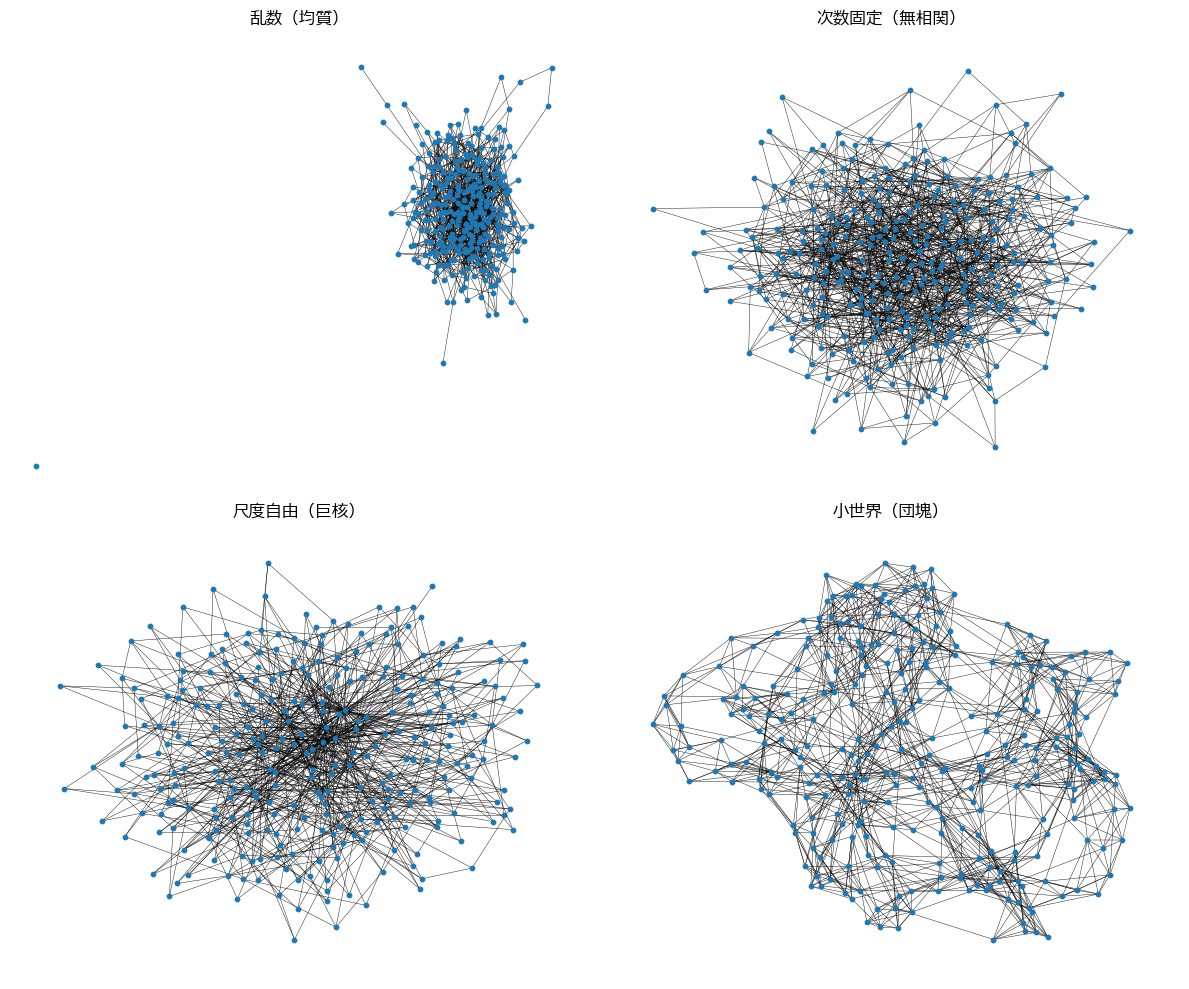

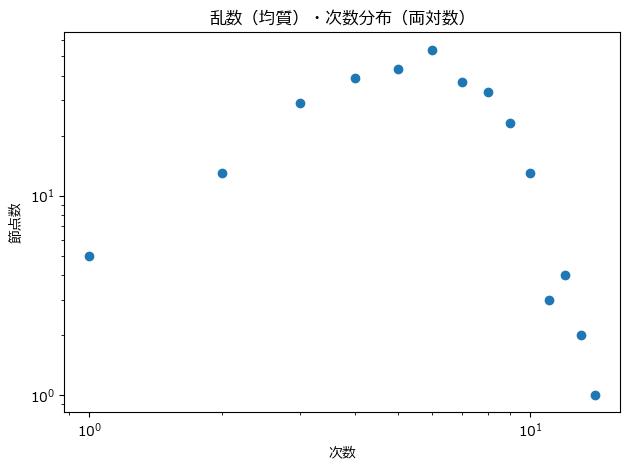

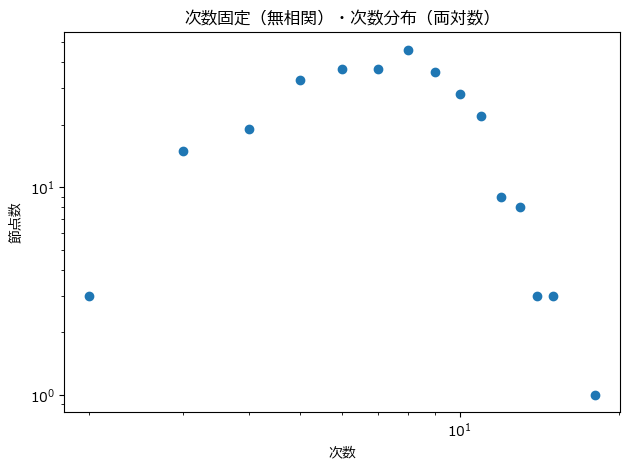

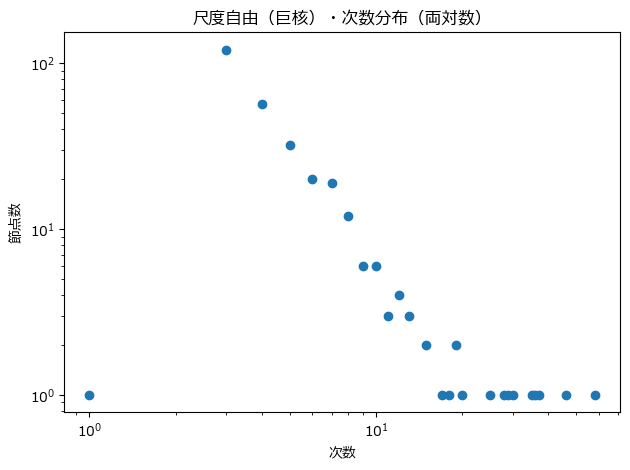

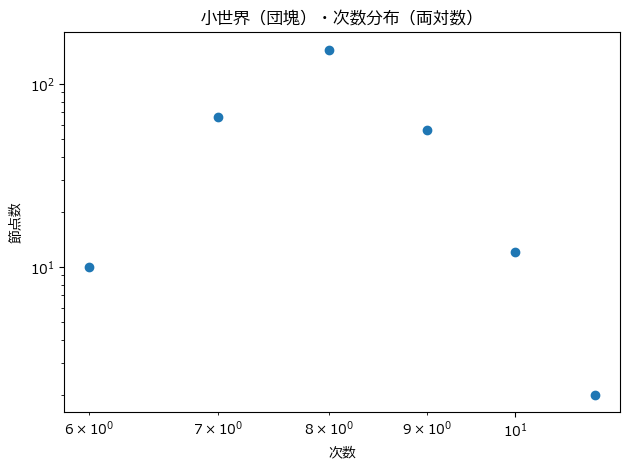

乱数（均質）
  節点数: 300
  辺数: 897
  密度: 0.02
  平均次数: 5.98
  次数分散: 5.9796
  最大次数: 14
  凝集係数（平均）: 0.0241107
  推移性（三角形率）: 0.0246085
  次数相関（アソータ）: 0.00856686
  連結成分数: 2
  最大連結成分（節点数）: 299
  平均最短距離（最大連結成分）: 3.39721
  直径（最大連結成分）: 7

次数固定（無相関）
  節点数: 300
  辺数: 1152
  密度: 0.0256856
  平均次数: 7.68
  次数分散: 7.61093
  最大次数: 18
  凝集係数（平均）: 0.0266185
  推移性（三角形率）: 0.0271585
  次数相関（アソータ）: 0.00480306
  連結成分数: 1
  最大連結成分（節点数）: 300
  平均最短距離（最大連結成分）: 3.01159
  直径（最大連結成分）: 5

尺度自由（巨核）
  節点数: 300
  辺数: 891
  密度: 0.0198662
  平均次数: 5.94
  次数分散: 39.5764
  最大次数: 58
  凝集係数（平均）: 0.0929086
  推移性（三角形率）: 0.0493326
  次数相関（アソータ）: -0.119034
  連結成分数: 1
  最大連結成分（節点数）: 300
  平均最短距離（最大連結成分）: 2.99851
  直径（最大連結成分）: 5

小世界（団塊）
  節点数: 300
  辺数: 1200
  密度: 0.0267559
  平均次数: 8
  次数分散: 0.76
  最大次数: 11
  凝集係数（平均）: 0.46958
  推移性（三角形率）: 0.459479
  次数相関（アソータ）: -0.0105566
  連結成分数: 1
  最大連結成分（節点数）: 300
  平均最短距離（最大連結成分）: 3.97996
  直径（最大連結成分）: 7



In [5]:
# pip install networkx matplotlib numpy
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import font_manager as fm

# -------------------------
# 日本語フォント（任意：漢字でも環境によっては必要）
# -------------------------
def set_japanese_font():
    candidates = ["Meiryo", "Yu Gothic", "Yu Gothic UI", "MS Gothic", "MS PGothic",
                  "Noto Sans CJK JP", "Noto Sans JP"]
    available = {f.name for f in fm.fontManager.ttflist}
    for name in candidates:
        if name in available:
            plt.rcParams["font.family"] = name
            break
    plt.rcParams["axes.unicode_minus"] = False

set_japanese_font()

# -------------------------
# 生成
# -------------------------
N = 300
seed = 0

# 1) ランダム（均質）
G_er = nx.erdos_renyi_graph(N, 0.02, seed=seed)

# 2) 次数固定（次数列を保つランダム）
rng = np.random.default_rng(seed)
deg_seq = rng.poisson(8, N)
if deg_seq.sum() % 2 == 1:
    deg_seq[0] += 1
G_cfg = nx.Graph(nx.configuration_model(deg_seq, seed=seed))
G_cfg.remove_edges_from(nx.selfloop_edges(G_cfg))

# 3) ハブ（優先選択）
G_ba = nx.barabasi_albert_graph(N, 3, seed=seed)

# 4) 団塊（高凝集＋短距離）
G_ws = nx.watts_strogatz_graph(N, 8, 0.1, seed=seed)

graphs = [
    (G_er,  "乱数（均質）"),
    (G_cfg, "次数固定（無相関）"),
    (G_ba,  "尺度自由（巨核）"),
    (G_ws,  "小世界（団塊）"),
]

# -------------------------
# 構造プロット
# -------------------------
plt.figure(figsize=(12, 10))
for i, (G, title) in enumerate(graphs):
    ax = plt.subplot(2, 2, i + 1)
    pos = nx.spring_layout(G, seed=seed)
    nx.draw(G, pos, node_size=10, width=0.3, ax=ax)
    ax.set_title(title)
plt.tight_layout()
plt.show()

# -------------------------
# 次数分布（log-log）
# -------------------------
def plot_degree_loglog(G, title):
    deg = np.array([d for _, d in G.degree()])
    values, counts = np.unique(deg, return_counts=True)

    plt.figure()
    plt.scatter(values, counts)
    plt.xscale("log")
    plt.yscale("log")
    plt.xlabel("次数")
    plt.ylabel("節点数")
    plt.title(title + "・次数分布（両対数）")
    plt.tight_layout()

for G, title in graphs:
    plot_degree_loglog(G, title)
plt.show()

# -------------------------
# 統計量表示（最大連結成分で距離系を計算）
# -------------------------
def graph_stats(G: nx.Graph) -> dict:
    n = G.number_of_nodes()
    m = G.number_of_edges()
    deg = np.array([d for _, d in G.degree()], dtype=float)

    # 連結成分
    if n == 0:
        return {}
    components = list(nx.connected_components(G))
    cc_count = len(components)
    lcc_nodes = max(components, key=len)
    lcc = G.subgraph(lcc_nodes).copy()

    # 距離系（LCC）
    lcc_n = lcc.number_of_nodes()
    if lcc_n >= 2:
        asp = nx.average_shortest_path_length(lcc)
        diam = nx.diameter(lcc)
    else:
        asp = np.nan
        diam = np.nan

    # 相関（次数相関：定義できない場合あり）
    try:
        assort = nx.degree_assortativity_coefficient(G)
    except Exception:
        assort = np.nan

    return {
        "節点数": n,
        "辺数": m,
        "密度": nx.density(G),
        "平均次数": float(deg.mean()) if n else np.nan,
        "次数分散": float(deg.var(ddof=0)) if n else np.nan,
        "最大次数": int(deg.max()) if n else 0,
        "凝集係数（平均）": nx.average_clustering(G) if n else np.nan,
        "推移性（三角形率）": nx.transitivity(G) if n else np.nan,
        "次数相関（アソータ）": assort,
        "連結成分数": cc_count,
        "最大連結成分（節点数）": lcc_n,
        "平均最短距離（最大連結成分）": asp,
        "直径（最大連結成分）": diam,
    }

def print_stats(title: str, stats: dict):
    print("====================================")
    print(title)
    for k, v in stats.items():
        if isinstance(v, float):
            if np.isnan(v):
                print(f"  {k}: NaN")
            else:
                print(f"  {k}: {v:.6g}")
        else:
            print(f"  {k}: {v}")
    print()

for G, title in graphs:
    print_stats(title, graph_stats(G))
